In [13]:
# load the human-judgements file
import os, json

# Path to the uploaded file
results_dir = '../competition/NIST_data/'

file_paths = [
    # 'final.citation_judgments_with_prediction.20241025.jsonl',
    'final.citation_judgments_Webassess.20241031.jsonl',
    'final.citation_judgments_without_prediction.20241025.jsonl'
]

# Initialize an empty list to store each row's JSON data
human_citation_data = {}

# Open the file and read line by line
for filepath in file_paths:
    file_path = os.path.join(results_dir, filepath)
    with open(file_path, 'r') as file:
        for idx, line in enumerate(file):
            json_data = json.loads(line)
            run_id = json_data['run_id']
            topic_id = json_data['topic_id']

            if topic_id not in human_citation_data:
                human_citation_data[topic_id] = {run_id: json_data}
            else:
                human_citation_data[topic_id][run_id] = json_data

In [14]:
print('Number of topics:', len(human_citation_data))

Number of topics: 22


In [15]:
RUNFILES = {
    "auggen": set([
        "ldisnu.ldilab_gpt_4o",
        "IIIA-UNIPD.iiia_dedup_p1_straight_ag",
        "IIIA-UNIPD.iiia_standard_p1_straight_ag",
        "softbank-meisei.agtask-bm25-colbert_faiss-gpt4o-llama70b",
        "CIR.cir_gpt-4o-mini_Cosine_50_0.5_100_301_p1",
        "CIR.cir_gpt-4o-mini_no_reranking_50_0.5_100_301_p1",
        "KML.gpt_mini",
        "KML.cohere+post_processing",
        "uis-iai.ginger_top_5",
        "uis-iai.baseline_top_5",
        "TREMA-UNH.Enhanced_Iterative_Fact_Refinement_and_Prioritization",
        "TREMA-UNH.Ranked_Iterative_Fact_Extraction_and_Refinement",
        "IITD-IRL.ag_rag_gpt35_expansion_rrf_20",
        "coordinators.baseline_rag24.test_l31_70b_instruct_top20",
    ]),
    "gen": set([
        "ldisnu.dilab_repllama_listt5_pass3_gpt4o",
        "WaterlooClarke.UWCgarag",
        "WaterlooClarke.UWCrag",
        "buw.oneshot_post_sentenced",
        "buw.buw",
        "citi.BEST_cot_gpt3.5",
        "citi.SECOND_cot_gpt3.5",
        "ielab.ielab-b70bf-70bqp-70bafs",
        "ielab.ielab-b70bf-70bqfs-ad_hoc",
        "ii_research.iiresearch-bm25-top10-llama3-8b-instruct",
        "InfoLab.UDInfolab.RAG.Query",
        "InfoLab.UDInfolab.RAG.AnsAI",
        "IRIT.ISIR-IRIT-zephyr_p2",
        "IRIT.ISIR-IRIT-zephyr_query_gen",
        "ncsu-las.LAS-splade-mxbai-rrf-mmr8",
        "ncsu-las.LAS-splade-mxbai-mmr8-RAG",
        "neu.neurag",
        "neu.neuragfix",
        "Ruc01.ruc001",
        "SGU.qrant_bge_gemini",
        "softbank-meisei.rag_bm25-colbert_faiss-gpt4o-llama70b",
        "webis.webis-manual",
        "webis.webis-rag-run0-taskrag",
        "webis.webis-rag-run1-taskrag",
        "IITD-IRL.zeph_test_rag_rrf_expand_query",
        "uog-tht.FT-llama3",
        "uog-tht.ICL-mistral",
        "coordinators.baseline_frag_rag24.test_gpt-4o_top20",
        "coordinators.baseline_frag_rag24.test_command-r-plus_top20",
        "h2oloo.listgalore_gpt4o_ragnarokv4_top20",
        "h2oloo.listgalore_l31-70b_ragnarokv4_top20",
    ])
}

In [16]:
# Load synthetic judgements by LLM
llm_results_directory = "/store/scratch/n3thakur/trec-rag-2024/trec2024-rag/support_eval/results/support/"

llm_citation_data = {}

for task in ["auggen", "gen"]:
    runfiles = RUNFILES[task]

    for runfile in runfiles:
        with open(os.path.join(llm_results_directory, task, "pairwise", f"{runfile}.jsonl"), "r") as file:
            for idx, line in enumerate(file):
                json_data = json.loads(line)
                json_data['sentences'] = json_data['support_eval']
                del json_data['support_eval']
                
                topic_id = json_data['topic_id']
                if topic_id in human_citation_data:
                    if topic_id not in llm_citation_data:
                        llm_citation_data[topic_id] = {runfile: {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}}
                    else:
                        llm_citation_data[topic_id][runfile] = {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}


In [17]:
print('Number of topics:', len(llm_citation_data))

Number of topics: 22


2024-129925
2024-142395
2024-158677
2024-213469
2024-213789
2024-217812
2024-219563
2024-219624
2024-27366
2024-35227
2024-35284
2024-35620
2024-96063
2024-143869
2024-217279
2024-29182
2024-32912
2024-41849
2024-96359
2024-213817
2024-214096
2024-158261
[[0.136903   0.15069712 0.05918125]
 [0.02773658 0.11940077 0.0978938 ]
 [0.01498072 0.08899436 0.3042124 ]]


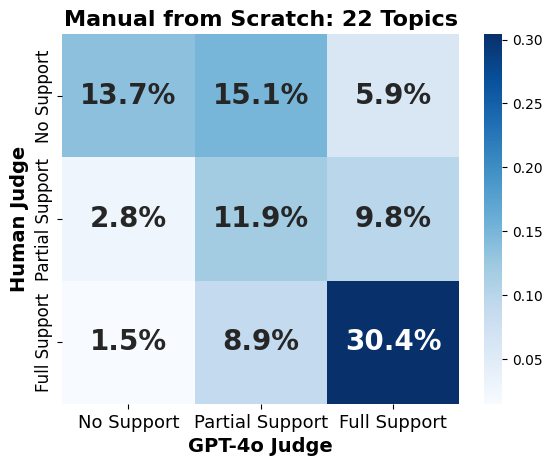

In [18]:
# Compare the confusion matrix of the human judgements and the LLM judgements
from sklearn.metrics import confusion_matrix

LLM_JUDGEMENT_DICT = {
    "FS": 2,
    "PS": 1,
    "NS": 0
}

y_true = []
y_pred = []
count = 0

for topic_id in human_citation_data:
    print(topic_id)
    for run_id in human_citation_data[topic_id]:
        human_pred = human_citation_data[topic_id][run_id]
        llm_pred = llm_citation_data[topic_id][run_id]

        # check if both sentences lengths are equal
        assert len(llm_pred["sentences"]) == len(human_pred["sentences"])
        references = llm_pred["references"]

        # go through each sentence one by one
        for human_sentence, llm_sentence in zip(human_pred["sentences"], llm_pred["sentences"]):

            try:
                if len(human_sentence['citations']) > 0:
                    if "citationId" in human_sentence['citations'][0]:
                        human_reference = human_sentence['citations'][0]['citationId']
                    else:
                        human_reference = human_sentence['citations'][0]['citationID']
                    
                    human_doc_id = human_sentence['citations'][0]['reference']

                    index = llm_sentence['citations'].index(human_reference)
                    llm_doc_id = references[llm_sentence['citations'][index]]

                    assert human_doc_id == llm_doc_id

                    human_judgement = int(human_sentence['citations'][0]['support'])
                    llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][index]]

                    if human_judgement != -1:
                        y_true.append(human_judgement)
                        y_pred.append(llm_judgement)
            except:
                if len(human_sentence['citations']) > 0:
                    
                    human_doc_id = human_sentence['citations'][0]['reference']
                    llm_doc_id = references[llm_sentence['citations'][0]]

                    assert human_doc_id == llm_doc_id

                    human_judgement = int(human_sentence['citations'][0]['support'])
                    llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][0]]

                    if human_judgement != -1:
                        y_true.append(human_judgement)
                        y_pred.append(llm_judgement)

confusion_matrix = confusion_matrix(y_true, y_pred)
sum_confusion_matrix = confusion_matrix.sum()
# divide the confusion matrix by the total number of samples
confusion_matrix = (confusion_matrix / sum_confusion_matrix)
print(confusion_matrix)

# convert the confusion matrix into a seaborn plot
import seaborn as sns
import matplotlib.pyplot as plt

res = sns.heatmap(confusion_matrix, annot=True, fmt='.1%', cmap='Blues', xticklabels=['No Support', 'Partial Support', 'Full Support'], yticklabels=['No Support', 'Partial Support', 'Full Support'], annot_kws={'size': 20, 'fontweight': 'bold'})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 13)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)

plt.xlabel('GPT-4o Judge', fontsize=14, fontweight='bold')
plt.ylabel('Human Judge', fontsize=14, fontweight='bold')
plt.title(f'Manual from Scratch: {len(human_citation_data)} Topics', fontweight='bold', fontsize=16)

# save the confusion matrix as a pdf file
plt.savefig('confusion_matrix_without_prediction.pdf', format='pdf', bbox_inches='tight')

In [25]:
print(y_true.count(2), y_true.count(1), y_true.count(0))
print(y_pred.count(2), y_pred.count(1), y_pred.count(0))

1812 1076 1277
2045 1330 790


In [20]:
# kendall tau correlation
from scipy.stats import kendalltau

overall_tau, _ = kendalltau(y_true, y_pred)
print(overall_tau)

0.6106237957358169


In [24]:
# load the human-judgements file
import csv

# Path to the uploaded file
results_dir = '../competition/NIST_data/'

file_paths = [
    'citation_topics_with_prediction.20241025',
    'citation_topics_Webassess.20241031',
    'citation_topics_without_prediction.20241025'
]

# Initialize an empty list to store each row's JSON data
topics_dict = {}

# Open the file and read line by line
for filepath in file_paths:
    file_path = os.path.join(results_dir, filepath)
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file, delimiter='\t')
        for idx, row in enumerate(csv_reader):
            topic_id = row[0]
            topic_name = row[1]
            topics_dict[topic_id] = topic_name

In [25]:
# load the human-judgements file
import os, json

# Path to the uploaded file
results_dir = '../competition/NIST_data/'

file_paths = [
    'final.citation_judgments_with_prediction.20241025.jsonl',
    'final.citation_judgments_Webassess.20241031.jsonl',
    'final.citation_judgments_without_prediction.20241025.jsonl'
]

# Initialize an empty list to store each row's JSON data
human_citation_data = {}

# Open the file and read line by line
for filepath in file_paths:
    file_path = os.path.join(results_dir, filepath)
    with open(file_path, 'r') as file:
        for idx, line in enumerate(file):
            json_data = json.loads(line)
            run_id = json_data['run_id']
            topic_id = json_data['topic_id']

            if topic_id not in human_citation_data:
                human_citation_data[topic_id] = {run_id: json_data}
            else:
                human_citation_data[topic_id][run_id] = json_data

In [26]:
print('Number of topics:', len(human_citation_data))

Number of topics: 36


In [27]:
# Load synthetic judgements by LLM
llm_results_directory = "/store/scratch/n3thakur/trec-rag-2024/trec2024-rag/support_eval/results/support/"

llm_citation_data = {}

for task in ["auggen", "gen"]:
    runfiles = RUNFILES[task]

    for runfile in runfiles:
        with open(os.path.join(llm_results_directory, task, "pairwise", f"{runfile}.jsonl"), "r") as file:
            for idx, line in enumerate(file):
                json_data = json.loads(line)
                json_data['sentences'] = json_data['support_eval']
                del json_data['support_eval']
                
                topic_id = json_data['topic_id']
                if topic_id in human_citation_data:
                    if topic_id not in llm_citation_data:
                        llm_citation_data[topic_id] = {runfile: {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}}
                    else:
                        llm_citation_data[topic_id][runfile] = {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}

print('Number of topics:', len(llm_citation_data))

Number of topics: 36


Text(0.5, 1.0, '')

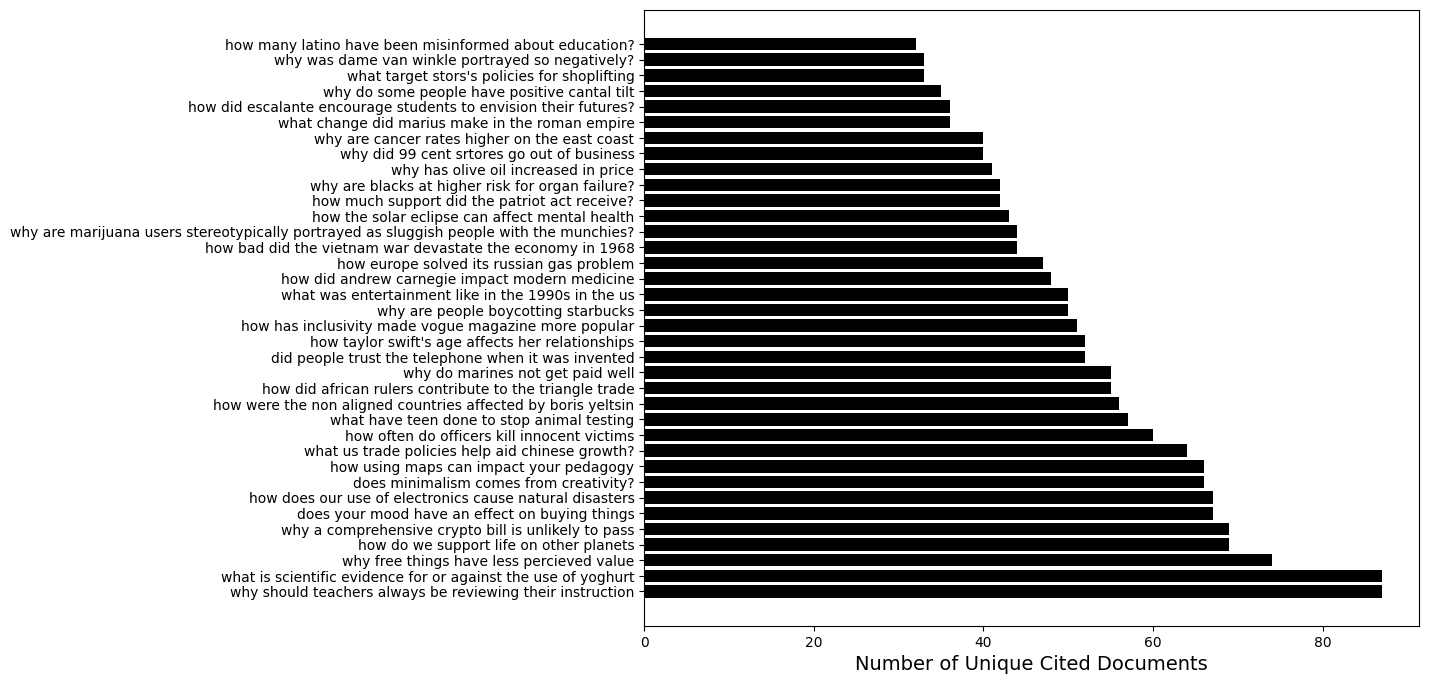

In [42]:
# Compare the confusion matrix of the human judgements and the LLM judgements
from sklearn.metrics import confusion_matrix

LLM_JUDGEMENT_DICT = {
    "FS": 2,
    "PS": 1,
    "NS": 0
}

y_true = []
y_pred = []
count = 0
unique_documents_per_topic = {}
unique_documents_per_topic_full_relevant = {}
unique_documents_per_topic_par_relevant = {}
unique_documents_per_topic_no_relevant = {}


for topic_id in human_citation_data:
    unique_documents_per_topic[topic_id] = set()
    unique_documents_per_topic_full_relevant[topic_id] = set()
    unique_documents_per_topic_par_relevant[topic_id] = set()
    unique_documents_per_topic_no_relevant[topic_id] = set()


    for run_id in human_citation_data[topic_id]:
        human_pred = human_citation_data[topic_id][run_id]
        llm_pred = llm_citation_data[topic_id][run_id]

        # check if both sentences lengths are equal
        assert len(llm_pred["sentences"]) == len(human_pred["sentences"])
        references = llm_pred["references"]

        # go through each sentence one by one
        for human_sentence, llm_sentence in zip(human_pred["sentences"], llm_pred["sentences"]):

            try:
                if len(human_sentence['citations']) > 0:
                    if "citationId" in human_sentence['citations'][0]:
                        human_reference = human_sentence['citations'][0]['citationId']
                    else:
                        human_reference = human_sentence['citations'][0]['citationID']
                    
                    human_doc_id = human_sentence['citations'][0]['reference']

                    index = llm_sentence['citations'].index(human_reference)
                    llm_doc_id = references[llm_sentence['citations'][index]]

                    assert human_doc_id == llm_doc_id

                    human_judgement = int(human_sentence['citations'][0]['support'])
                    llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][index]]

                    if human_judgement != -1:
                        if human_judgement == 2:
                            unique_documents_per_topic_full_relevant[topic_id].add(human_doc_id)
                        elif human_judgement == 1:
                            unique_documents_per_topic_par_relevant[topic_id].add(human_doc_id)
                        else:
                            unique_documents_per_topic_no_relevant[topic_id].add(human_doc_id)

                        unique_documents_per_topic[topic_id].add(human_doc_id)

            except:
                if len(human_sentence['citations']) > 0:
                    
                    human_doc_id = human_sentence['citations'][0]['reference']
                    llm_doc_id = references[llm_sentence['citations'][0]]

                    assert human_doc_id == llm_doc_id

                    human_judgement = int(human_sentence['citations'][0]['support'])
                    llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][0]]

                    if human_judgement != -1:
                        if human_judgement == 2:
                            unique_documents_per_topic_full_relevant[topic_id].add(human_doc_id)
                        elif human_judgement == 1:
                            unique_documents_per_topic_par_relevant[topic_id].add(human_doc_id)
                        else:
                            unique_documents_per_topic_no_relevant[topic_id].add(human_doc_id)
                        
                        unique_documents_per_topic[topic_id].add(human_doc_id)

# plot a barplot of the number of unique documents per topic
import matplotlib.pyplot as plt
import numpy as np

# sort the topics by the number of unique documents
unique_documents_per_topic = {k: v for k, v in sorted(unique_documents_per_topic.items(), key=lambda item: len(item[1]), reverse=True)}

# get the number of unique documents per topic for fully relevant, partially relevant and not relevant

topics = list(unique_documents_per_topic.keys())
num_unique_documents = [len(unique_documents_per_topic[topic]) for topic in topics]

plt.figure(figsize=(10, 8))
plt.barh(topics, num_unique_documents, color='black')

# rotate xticks
plt.yticks(topics, [topics_dict[topic] for topic in topics])

plt.ylabel('', fontsize=14)
plt.xlabel('Number of Unique Cited Documents', fontsize=14)
plt.title('', fontsize=16)

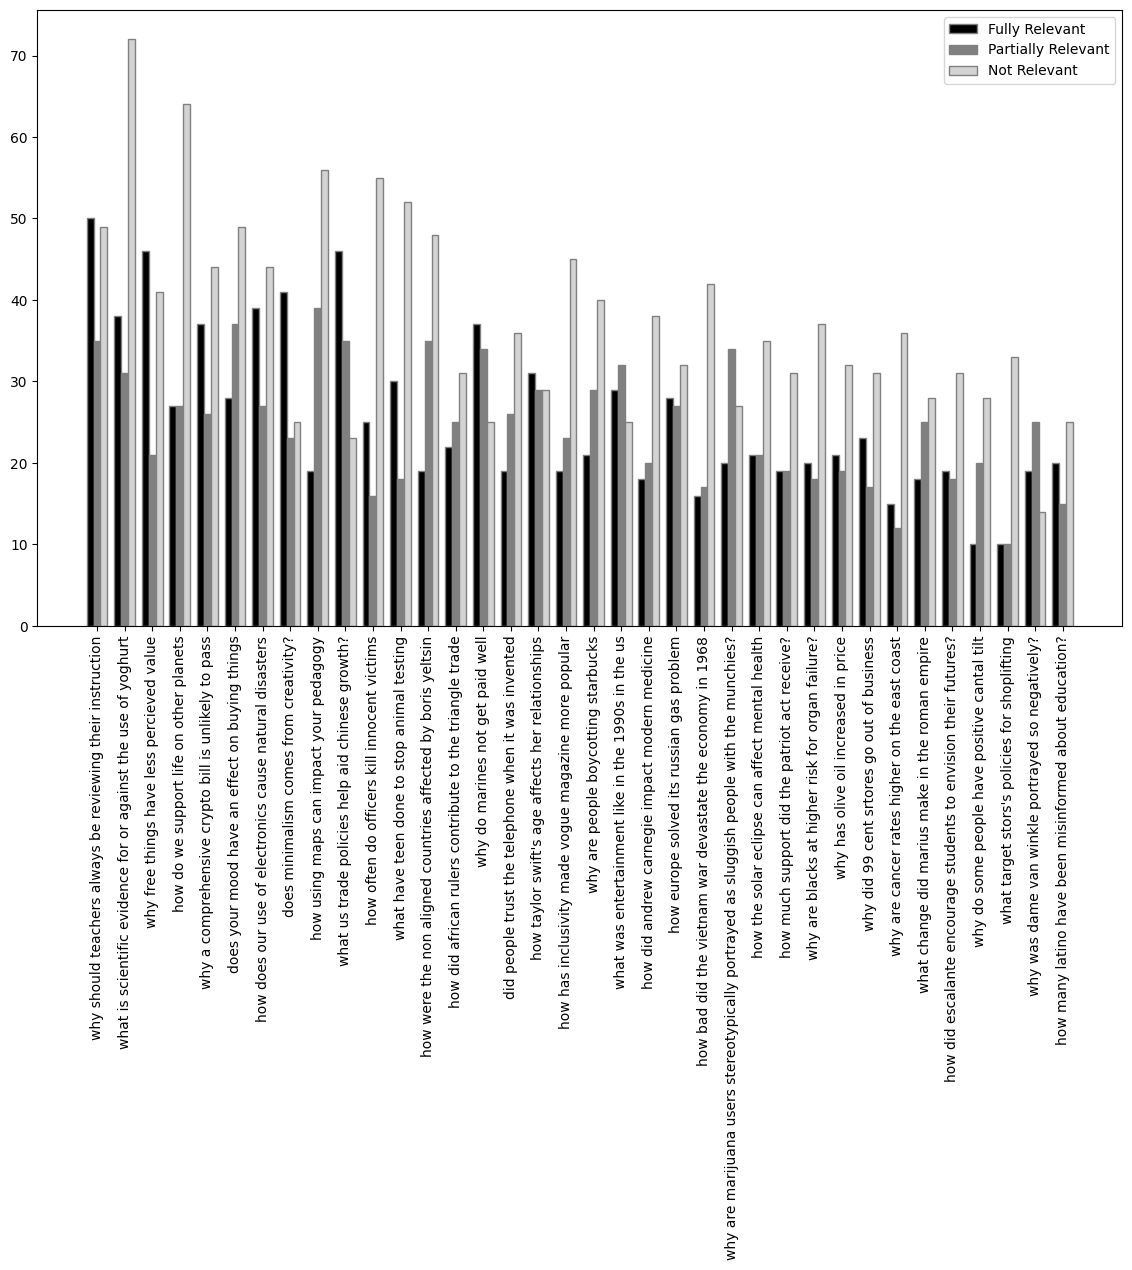

In [47]:
# Compare the confusion matrix of the human judgements and the LLM judgements
from sklearn.metrics import confusion_matrix

LLM_JUDGEMENT_DICT = {
    "FS": 2,
    "PS": 1,
    "NS": 0
}

y_true = []
y_pred = []
count = 0
unique_documents_per_topic = {}
unique_documents_per_topic_full_relevant = {}
unique_documents_per_topic_par_relevant = {}
unique_documents_per_topic_no_relevant = {}


for topic_id in human_citation_data:
    unique_documents_per_topic[topic_id] = set()
    unique_documents_per_topic_full_relevant[topic_id] = set()
    unique_documents_per_topic_par_relevant[topic_id] = set()
    unique_documents_per_topic_no_relevant[topic_id] = set()


    for run_id in human_citation_data[topic_id]:
        human_pred = human_citation_data[topic_id][run_id]
        llm_pred = llm_citation_data[topic_id][run_id]

        # check if both sentences lengths are equal
        assert len(llm_pred["sentences"]) == len(human_pred["sentences"])
        references = llm_pred["references"]

        # go through each sentence one by one
        for human_sentence, llm_sentence in zip(human_pred["sentences"], llm_pred["sentences"]):

            try:
                if len(human_sentence['citations']) > 0:
                    if "citationId" in human_sentence['citations'][0]:
                        human_reference = human_sentence['citations'][0]['citationId']
                    else:
                        human_reference = human_sentence['citations'][0]['citationID']
                    
                    human_doc_id = human_sentence['citations'][0]['reference']

                    index = llm_sentence['citations'].index(human_reference)
                    llm_doc_id = references[llm_sentence['citations'][index]]

                    assert human_doc_id == llm_doc_id

                    human_judgement = int(human_sentence['citations'][0]['support'])
                    llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][index]]

                    if human_judgement != -1:
                        if human_judgement == 2:
                            unique_documents_per_topic_full_relevant[topic_id].add(human_doc_id)
                        elif human_judgement == 1:
                            unique_documents_per_topic_par_relevant[topic_id].add(human_doc_id)
                        else:
                            unique_documents_per_topic_no_relevant[topic_id].add(human_doc_id)

                        unique_documents_per_topic[topic_id].add(human_doc_id)

            except:
                if len(human_sentence['citations']) > 0:
                    
                    human_doc_id = human_sentence['citations'][0]['reference']
                    llm_doc_id = references[llm_sentence['citations'][0]]

                    assert human_doc_id == llm_doc_id

                    human_judgement = int(human_sentence['citations'][0]['support'])
                    llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][0]]

                    if human_judgement != -1:
                        if human_judgement == 2:
                            unique_documents_per_topic_full_relevant[topic_id].add(human_doc_id)
                        elif human_judgement == 1:
                            unique_documents_per_topic_par_relevant[topic_id].add(human_doc_id)
                        else:
                            unique_documents_per_topic_no_relevant[topic_id].add(human_doc_id)
                        
                        unique_documents_per_topic[topic_id].add(human_doc_id)

# plot a barplot of the number of unique documents per topic
import matplotlib.pyplot as plt
import numpy as np

# sort the topics by the number of unique documents
unique_documents_per_topic = {k: v for k, v in sorted(unique_documents_per_topic.items(), key=lambda item: len(item[1]), reverse=True)}

# get the number of unique documents per topic for fully relevant, partially relevant and not relevant

topics = list(unique_documents_per_topic.keys())
full_relevant_unique_documents = [len(unique_documents_per_topic_full_relevant[topic]) for topic in topics]
par_relevant_unique_documents = [len(unique_documents_per_topic_par_relevant[topic]) for topic in topics]
no_relevant_unique_documents = [len(unique_documents_per_topic_no_relevant[topic]) for topic in topics]

# plot a stacked bar plot
plt.figure(figsize=(14, 8))
barWidth = 0.25
r1 = np.arange(len(topics))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, full_relevant_unique_documents, color='black', width=barWidth, edgecolor='grey', label='Fully Relevant')
plt.bar(r2, par_relevant_unique_documents, color='grey', width=barWidth, edgecolor='grey', label='Partially Relevant')
plt.bar(r3, no_relevant_unique_documents, color='lightgrey', width=barWidth, edgecolor='grey', label='Not Relevant')
plt.legend()

# rotate xticks
plt.xticks([r + barWidth for r in range(len(topics))], [topics_dict[topic] for topic in topics], rotation=90)
plt.show()


# plt.figure(figsize=(10, 8))
# plt.barh(topics, num_unique_documents, color='black')

# # rotate xticks
# plt.yticks(topics, [topics_dict[topic] for topic in topics])

# plt.ylabel('', fontsize=14)
# plt.xlabel('Number of Unique Cited Documents', fontsize=14)
# plt.title('', fontsize=16)

In [108]:
# import qrels

qrels_file_manual = '/store/scratch/n3thakur/trec-rag-2024/trec2024-rag/qrels/RAG2024_qrels-2024-09-27-1.txt'

qrels_manual = {}
with open(qrels_file_manual, 'r') as file:
     lines = [line.strip() for line in file.readlines()]
     for line in lines:
        query_id = line.split()[0]
        doc_id = line.split()[2]
        relevance = int(line.split()[3])
        if query_id not in qrels_manual:
            qrels_manual[query_id] = {doc_id: relevance}
        else:
            qrels_manual[query_id][doc_id] = relevance

In [109]:
# load the human-judgements file
import os, json

# Path to the uploaded file
results_dir = '../competition/NIST_data/'
# file_paths = [
#     'final.citation_judgments_Webassess.20241031.jsonl', 
#     'final.citation_judgments_with_prediction.20241025.jsonl',
#     'final.citation_judgments_without_prediction.20241025.jsonl'
# ]
file_paths = [
    'final.citation_judgments_with_prediction.20241025.jsonl',
    'final.citation_judgments_Webassess.20241031.jsonl',
    'final.citation_judgments_without_prediction.20241025.jsonl'
]

# Initialize an empty list to store each row's JSON data
human_citation_data = {}

# Open the file and read line by line
for filepath in file_paths:
    file_path = os.path.join(results_dir, filepath)
    with open(file_path, 'r') as file:
        for idx, line in enumerate(file):
            json_data = json.loads(line)
            run_id = json_data['run_id']
            topic_id = json_data['topic_id']

            if topic_id not in human_citation_data:
                human_citation_data[topic_id] = {run_id: json_data}
            else:
                human_citation_data[topic_id][run_id] = json_data

In [110]:
# Load synthetic judgements by LLM
llm_results_directory = "/store/scratch/n3thakur/trec-rag-2024/trec2024-rag/support_eval/results/support/"

llm_citation_data = {}

for task in ["auggen", "gen"]:
    runfiles = RUNFILES[task]

    for runfile in runfiles:
        with open(os.path.join(llm_results_directory, task, "pairwise", f"{runfile}.jsonl"), "r") as file:
            for idx, line in enumerate(file):
                json_data = json.loads(line)
                json_data['sentences'] = json_data['support_eval']
                del json_data['support_eval']
                
                topic_id = json_data['topic_id']
                if topic_id in human_citation_data:
                    if topic_id not in llm_citation_data:
                        llm_citation_data[topic_id] = {runfile: {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}}
                    else:
                        llm_citation_data[topic_id][runfile] = {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}


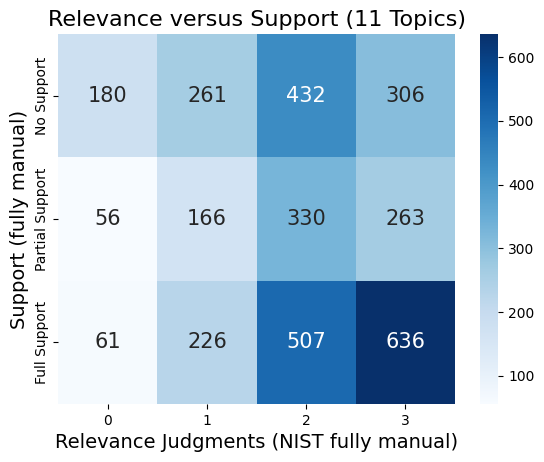

In [111]:
# Compare the confusion matrix of the human judgements and the LLM judgements
from sklearn.metrics import confusion_matrix

LLM_JUDGEMENT_DICT = {
    "FS": 2,
    "PS": 1,
    "NS": 0
}

y_support = []
y_rel = []
count = 0

for topic_id in human_citation_data:
    if topic_id in qrels_manual:
        count += 1
        for run_id in human_citation_data[topic_id]:
            human_pred = human_citation_data[topic_id][run_id]
            llm_pred = llm_citation_data[topic_id][run_id]

            # check if both sentences lengths are equal
            assert len(llm_pred["sentences"]) == len(human_pred["sentences"])
            references = llm_pred["references"]

            # go through each sentence one by one
            for human_sentence, llm_sentence in zip(human_pred["sentences"], llm_pred["sentences"]):

                try:
                    if len(human_sentence['citations']) > 0:
                        if "citationId" in human_sentence['citations'][0]:
                            human_reference = human_sentence['citations'][0]['citationId']
                        else:
                            human_reference = human_sentence['citations'][0]['citationID']
                        
                        human_doc_id = human_sentence['citations'][0]['reference']

                        index = llm_sentence['citations'].index(human_reference)
                        llm_doc_id = references[llm_sentence['citations'][index]]

                        assert human_doc_id == llm_doc_id

                        human_judgement = int(human_sentence['citations'][0]['support'])
                        llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][index]]

                        if human_judgement != -1:
                            y_support.append(human_judgement)
                            y_rel.append(qrels_manual[topic_id][human_doc_id])
                except:
                    if len(human_sentence['citations']) > 0:
                        
                        human_doc_id = human_sentence['citations'][0]['reference']
                        llm_doc_id = references[llm_sentence['citations'][0]]

                        assert human_doc_id == llm_doc_id

                        human_judgement = int(human_sentence['citations'][0]['support'])
                        llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][0]]

                        if human_judgement != -1:
                            y_support.append(human_judgement)
                            y_rel.append(qrels_manual[topic_id][human_doc_id])

confusion_matrix = confusion_matrix(y_support, y_rel)

# convert the confusion matrix into a seaborn plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix[0:3], annot=True, fmt='d', cmap='Blues', annot_kws={'size': 15}, yticklabels=['No Support', 'Partial Support', 'Full Support'])
plt.xlabel('Relevance Judgments (NIST fully manual)', fontsize=14)
plt.ylabel('Support (fully manual)', fontsize=14)
plt.title(f'Relevance versus Support ({count} Topics)', fontsize=16)

# save the confusion matrix as a pdf file
plt.savefig('confusion_matrix_support_manual_relevance_manual.pdf', format='pdf', bbox_inches='tight')

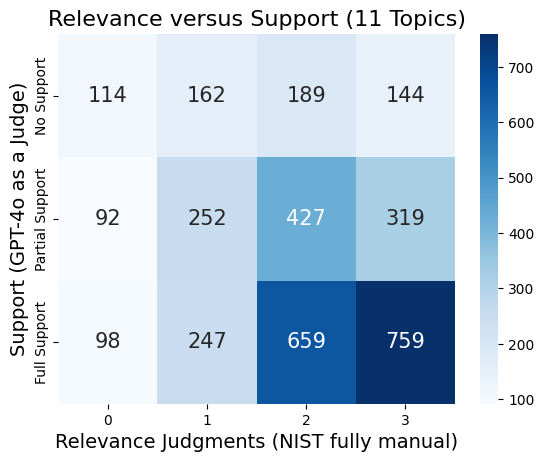

In [87]:
# Compare the confusion matrix of the human judgements and the LLM judgements
from sklearn.metrics import confusion_matrix

LLM_JUDGEMENT_DICT = {
    "FS": 2,
    "PS": 1,
    "NS": 0
}

y_support = []
y_rel = []
count = 0

for topic_id in human_citation_data:
    if topic_id in qrels_manual:
        count += 1
        for run_id in human_citation_data[topic_id]:
            human_pred = human_citation_data[topic_id][run_id]
            llm_pred = llm_citation_data[topic_id][run_id]

            # check if both sentences lengths are equal
            assert len(llm_pred["sentences"]) == len(human_pred["sentences"])
            references = llm_pred["references"]

            # go through each sentence one by one
            for human_sentence, llm_sentence in zip(human_pred["sentences"], llm_pred["sentences"]):

                try:
                    if len(human_sentence['citations']) > 0:
                        if "citationId" in human_sentence['citations'][0]:
                            human_reference = human_sentence['citations'][0]['citationId']
                        else:
                            human_reference = human_sentence['citations'][0]['citationID']
                        
                        human_doc_id = human_sentence['citations'][0]['reference']

                        index = llm_sentence['citations'].index(human_reference)
                        llm_doc_id = references[llm_sentence['citations'][index]]

                        assert human_doc_id == llm_doc_id

                        human_judgement = int(human_sentence['citations'][0]['support'])
                        llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][index]]

                        y_support.append(llm_judgement)
                        y_rel.append(qrels_manual[topic_id][human_doc_id])
                except:
                    if len(human_sentence['citations']) > 0:
                        
                        human_doc_id = human_sentence['citations'][0]['reference']
                        llm_doc_id = references[llm_sentence['citations'][0]]

                        assert human_doc_id == llm_doc_id

                        human_judgement = int(human_sentence['citations'][0]['support'])
                        llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][0]]

                        y_support.append(llm_judgement)
                        y_rel.append(qrels_manual[topic_id][human_doc_id])

confusion_matrix = confusion_matrix(y_support, y_rel)

# convert the confusion matrix into a seaborn plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix[0:3], annot=True, fmt='d', cmap='Blues', annot_kws={'size': 15}, yticklabels=['No Support', 'Partial Support', 'Full Support'])
plt.xlabel('Relevance Judgments (NIST fully manual)', fontsize=14)
plt.ylabel('Support (GPT-4o as a Judge)', fontsize=14)
plt.title(f'Relevance versus Support ({count} Topics)', fontsize=16)

# save the confusion matrix as a pdf file
plt.savefig('confusion_matrix_support_auto_relevance_manual.pdf', format='pdf', bbox_inches='tight')

In [103]:
# import qrels

qrels_file_auto = '/store/scratch/n3thakur/trec-rag-2024/trec2024-rag/umbrela_eval/trec-rag-test_gpt4o_0123_100_0_1.txt'

qrels_auto = {}
with open(qrels_file_auto, 'r') as file:
     lines = [line.strip() for line in file.readlines()]
     for line in lines:
        query_id = line.split()[0]
        doc_id = line.split()[2]
        relevance = int(line.split()[3])
        if query_id not in qrels_auto:
            qrels_auto[query_id] = {doc_id: relevance}
        else:
            qrels_auto[query_id][doc_id] = relevance

In [104]:
# load the human-judgements file
import os, json

# Path to the uploaded file
results_dir = '../competition/NIST_data/'
# file_paths = [
#     'final.citation_judgments_Webassess.20241031.jsonl', 
#     'final.citation_judgments_with_prediction.20241025.jsonl',
#     'final.citation_judgments_without_prediction.20241025.jsonl'
# ]
file_paths = [
    'final.citation_judgments_with_prediction.20241025.jsonl',
    'final.citation_judgments_Webassess.20241031.jsonl',
    'final.citation_judgments_without_prediction.20241025.jsonl'
]

# Initialize an empty list to store each row's JSON data
human_citation_data = {}

# Open the file and read line by line
for filepath in file_paths:
    file_path = os.path.join(results_dir, filepath)
    with open(file_path, 'r') as file:
        for idx, line in enumerate(file):
            json_data = json.loads(line)
            run_id = json_data['run_id']
            topic_id = json_data['topic_id']

            if topic_id not in human_citation_data:
                human_citation_data[topic_id] = {run_id: json_data}
            else:
                human_citation_data[topic_id][run_id] = json_data

In [105]:
# Load synthetic judgements by LLM
llm_results_directory = "/store/scratch/n3thakur/trec-rag-2024/trec2024-rag/support_eval/results/support/"

llm_citation_data = {}

for task in ["auggen", "gen"]:
    runfiles = RUNFILES[task]

    for runfile in runfiles:
        with open(os.path.join(llm_results_directory, task, "pairwise", f"{runfile}.jsonl"), "r") as file:
            for idx, line in enumerate(file):
                json_data = json.loads(line)
                json_data['sentences'] = json_data['support_eval']
                del json_data['support_eval']
                
                topic_id = json_data['topic_id']
                if topic_id in human_citation_data:
                    if topic_id not in llm_citation_data:
                        llm_citation_data[topic_id] = {runfile: {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}}
                    else:
                        llm_citation_data[topic_id][runfile] = {"topic_id": topic_id, "run_id": runfile, "sentences": json_data["sentences"], "references": json_data["references"]}


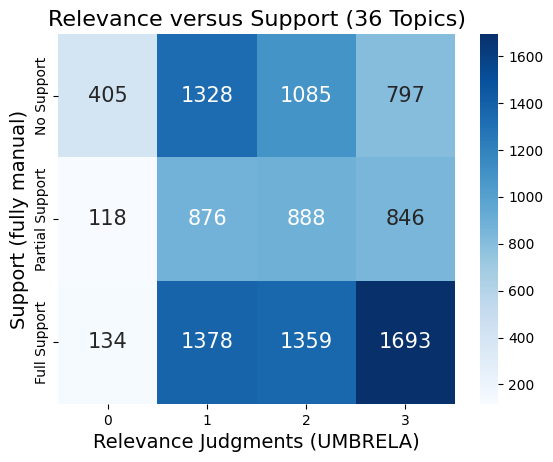

In [106]:
# Compare the confusion matrix of the human judgements and the LLM judgements
from sklearn.metrics import confusion_matrix

LLM_JUDGEMENT_DICT = {
    "FS": 2,
    "PS": 1,
    "NS": 0
}

y_support = []
y_rel = []
count = 0

for topic_id in human_citation_data:
    if topic_id in qrels_auto:
        count += 1
        for run_id in human_citation_data[topic_id]:
            human_pred = human_citation_data[topic_id][run_id]
            llm_pred = llm_citation_data[topic_id][run_id]

            # check if both sentences lengths are equal
            assert len(llm_pred["sentences"]) == len(human_pred["sentences"])
            references = llm_pred["references"]

            # go through each sentence one by one
            for human_sentence, llm_sentence in zip(human_pred["sentences"], llm_pred["sentences"]):

                try:
                    if len(human_sentence['citations']) > 0:
                        if "citationId" in human_sentence['citations'][0]:
                            human_reference = human_sentence['citations'][0]['citationId']
                        else:
                            human_reference = human_sentence['citations'][0]['citationID']
                        
                        human_doc_id = human_sentence['citations'][0]['reference']

                        index = llm_sentence['citations'].index(human_reference)
                        llm_doc_id = references[llm_sentence['citations'][index]]

                        assert human_doc_id == llm_doc_id

                        human_judgement = int(human_sentence['citations'][0]['support'])
                        llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][index]]

                        if human_judgement != -1:
                            y_support.append(human_judgement)
                            y_rel.append(qrels_auto[topic_id][human_doc_id])
                except:
                    if len(human_sentence['citations']) > 0:
                        
                        human_doc_id = human_sentence['citations'][0]['reference']
                        llm_doc_id = references[llm_sentence['citations'][0]]

                        assert human_doc_id == llm_doc_id

                        human_judgement = int(human_sentence['citations'][0]['support'])
                        llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][0]]

                        if human_judgement != -1:
                            y_support.append(human_judgement)
                            y_rel.append(qrels_auto[topic_id][human_doc_id])

confusion_matrix = confusion_matrix(y_support, y_rel)

# convert the confusion matrix into a seaborn plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix[0:3], annot=True, fmt='d', cmap='Blues', annot_kws={'size': 15}, yticklabels=['No Support', 'Partial Support', 'Full Support'])
plt.xlabel('Relevance Judgments (UMBRELA)', fontsize=14)
plt.ylabel('Support (fully manual)', fontsize=14)
plt.title(f'Relevance versus Support ({count} Topics)', fontsize=16)

# save the confusion matrix as a pdf file
plt.savefig('confusion_matrix_support_manual_relevance_auto.pdf', format='pdf', bbox_inches='tight')

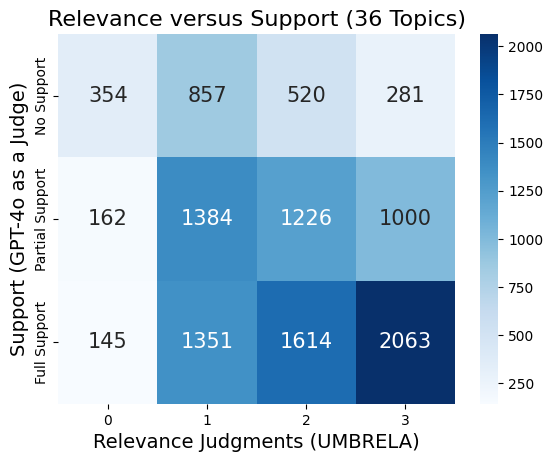

In [107]:
# Compare the confusion matrix of the human judgements and the LLM judgements
from sklearn.metrics import confusion_matrix

LLM_JUDGEMENT_DICT = {
    "FS": 2,
    "PS": 1,
    "NS": 0
}

y_support = []
y_rel = []
count = 0

for topic_id in human_citation_data:
    if topic_id in qrels_auto:
        count += 1
        for run_id in human_citation_data[topic_id]:
            human_pred = human_citation_data[topic_id][run_id]
            llm_pred = llm_citation_data[topic_id][run_id]

            # check if both sentences lengths are equal
            assert len(llm_pred["sentences"]) == len(human_pred["sentences"])
            references = llm_pred["references"]

            # go through each sentence one by one
            for human_sentence, llm_sentence in zip(human_pred["sentences"], llm_pred["sentences"]):

                try:
                    if len(human_sentence['citations']) > 0:
                        if "citationId" in human_sentence['citations'][0]:
                            human_reference = human_sentence['citations'][0]['citationId']
                        else:
                            human_reference = human_sentence['citations'][0]['citationID']
                        
                        human_doc_id = human_sentence['citations'][0]['reference']

                        index = llm_sentence['citations'].index(human_reference)
                        llm_doc_id = references[llm_sentence['citations'][index]]

                        assert human_doc_id == llm_doc_id

                        human_judgement = int(human_sentence['citations'][0]['support'])
                        llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][index]]

                        y_support.append(llm_judgement)
                        y_rel.append(qrels_auto[topic_id][human_doc_id])
                except:
                    if len(human_sentence['citations']) > 0:
                        
                        human_doc_id = human_sentence['citations'][0]['reference']
                        llm_doc_id = references[llm_sentence['citations'][0]]

                        assert human_doc_id == llm_doc_id

                        human_judgement = int(human_sentence['citations'][0]['support'])
                        llm_judgement = LLM_JUDGEMENT_DICT[llm_sentence['eval_scores'][0]]

                        y_support.append(llm_judgement)
                        y_rel.append(qrels_auto[topic_id][human_doc_id])

confusion_matrix = confusion_matrix(y_support, y_rel)

# convert the confusion matrix into a seaborn plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix[0:3], annot=True, fmt='d', cmap='Blues', annot_kws={'size': 15}, yticklabels=['No Support', 'Partial Support', 'Full Support'])
plt.xlabel('Relevance Judgments (UMBRELA)', fontsize=14)
plt.ylabel('Support (GPT-4o as a Judge)', fontsize=14)
plt.title(f'Relevance versus Support ({count} Topics)', fontsize=16)

# save the confusion matrix as a pdf file
plt.savefig('confusion_matrix_support_auto_relevance_auto.pdf', format='pdf', bbox_inches='tight')